In [1]:
import glob
import os
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import ipywidgets as widgets

# geospatial 
import regionmask 
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.stats import theilslopes
from ismn.interface import ISMN_Interface

import warnings
warnings.simplefilter("ignore")

Data is again quite large and therefore isn't loaded in a second time: 

In [2]:
path = os.getcwd()
# fixing local link_path, change here where you installed the link dataset mentioned below
ENVM1502_link_path = os.path.dirname(os.path.dirname(os.path.dirname(path)))
ENVM1502_data_path = f'{ENVM1502_link_path}\\Unit 2\\Ex3 - Soil moisture\\'

soil_moisture_path  = f'{os.path.dirname(path)}\\Data\\Soilmoisture'
gis_folder         = f'{os.path.dirname(path)}\\GIS'


Load geospatial data

In [3]:
# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="SHP",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
outline_buffered  = gpd.read_file(f"{gis_folder}\\hudson_basin_buffered.gpkg",crs="EPSG:26918")

# fixing crs
for layer in [outline,main_rivers,all_rivers, outline_buffered]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

# In situ
Inital parts for in situ soil measurement, downloaded from https://ismn.earth/en/data/, site [Lye Brook 2042](https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=2042)

Found existing ismn metadata in C:\Users\david\Documents\@@ Python\Jaar 5\Q3\ENVM1502\Git\ENVM1502-Catchment-model\Data\Soilmoisture\python_metadata\Soilmoisture.csv.


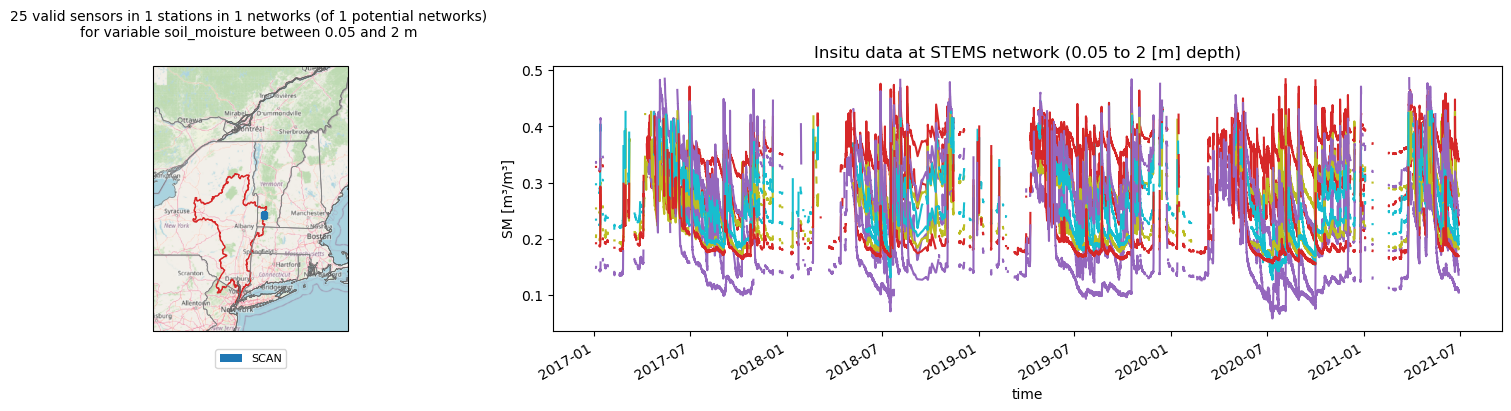

In [4]:
request = OSM()

ismn = ISMN_Interface(soil_moisture_path)
stems = None

depth = (0.05, 2)
def read_ismn(depth):
    min_depth, max_depth = depth

    fig = plt.figure(figsize=(15,4), constrained_layout=True)
    gs = fig.add_gridspec(1, 3)
    map_ax, ts_ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()), fig.add_subplot(gs[0, 1:])
    
    # Plot a small overview map with station locations over Open Street Map
    ismn.plot_station_locations(variable='soil_moisture', min_depth=min_depth, max_depth=max_depth, markersize=5, text_scalefactor=2, stats_text=True, ax=map_ax)
    map_ax.set_extent([-77,-70,40,47])
    map_ax.add_image(request, 6)
    outline.plot(ax=map_ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=map_ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=map_ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)
    

     # Extract the sensors in the chosen depths at the locations and store their data
    sensors = []
    for network, station, sensor in ismn.collection.iter_sensors(variable='soil_moisture', depth=(min_depth, max_depth)):
        data = sensor.read_data()
        data.loc[data['soil_moisture_flag'] != 'G', 'soil_moisture'] = np.nan
        data = data['soil_moisture']
        if sensor.depth[0] == sensor.depth[1]:
            depth = f"{sensor.depth[0]}"
        else:
            depth = f"{sensor.depth[0]}-{sensor.depth[1]}"
        data.name = f"{station.name} ({depth} m)"
        sensors.append(data)
    
    global stems
    stems = pd.concat(sensors, axis=1)
    
    stems_plot = stems.loc['2017-01-01':,:]
    
    p = stems_plot.plot(ax=ts_ax, xlabel='time', ylabel='SM [m³/m³]', title=f'Insitu data at STEMS network ({min_depth} to {max_depth} [m] depth)')
    p.legend().remove()

read_ismn(depth)

Text(0.5, 1.0, 'Combined')

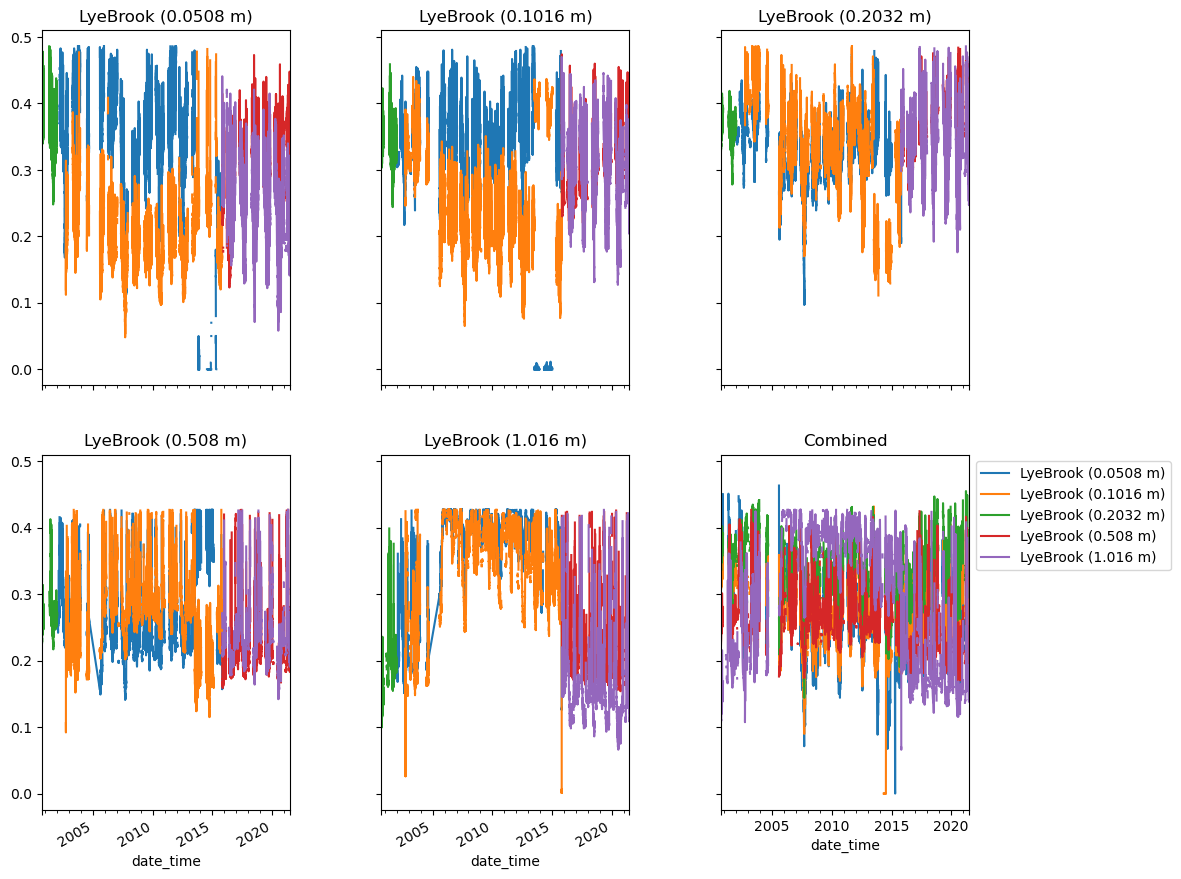

In [5]:
unique_val_cols = stems.columns.unique()
n = len(unique_val_cols)
fig, ax = plt.subplots(int((n+1)/3),3,figsize=(10,10),sharex=True,sharey=True)
fig.tight_layout(w_pad=5, h_pad=5)
lst_dfs = []
ax = ax.flatten()
for index, col in enumerate(unique_val_cols):
    df_depth = stems[col]
    lst_dfs.append(pd.DataFrame(data=df_depth.mean(axis=1).resample("d").mean(),columns=[col]))
    df_depth.plot(ax=ax[index])
    ax[index].legend().remove()
    ax[index].set_title(col)
stems_merged = pd.concat(lst_dfs,axis=1)
stems_merged.plot(ax=ax[-1])
ax[-1].legend(bbox_to_anchor=(1,1))
ax[-1].set_title("Combined")

The plot above shows the uncertainty in the data as different sensors report differently over time. Daily averages can be obtained by taking the mean of the observations and then resampelinig on a daily basis. 

# Microwave remote sensing -  Soil Moisture Active Passive Mission (SMAP)

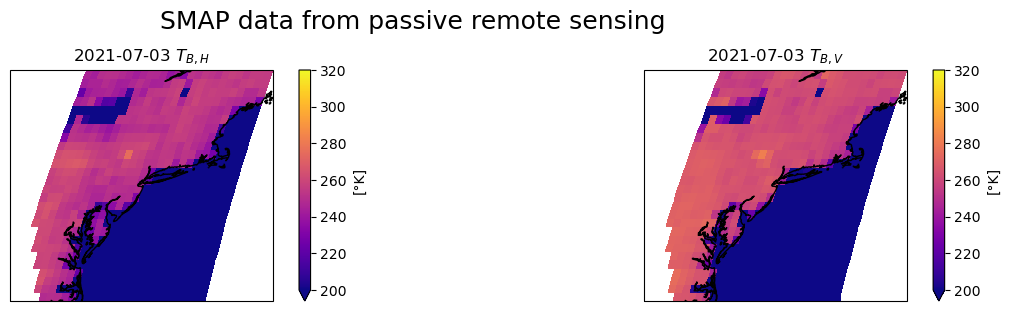

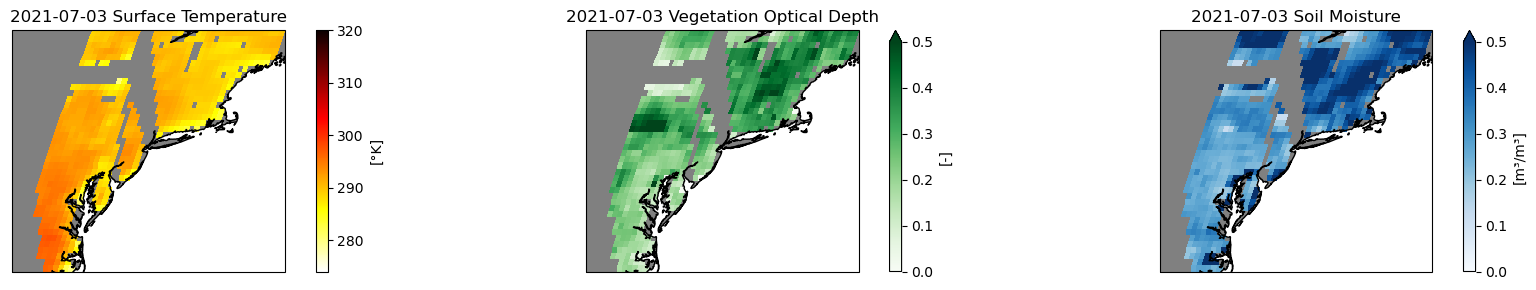

In [6]:
year,month,day  = 2021, 7, 3
date = f'{year}-{month:02}-{day:02}'

y = 40.48908101650877
x = -74.0305856727883
n_x = 5
n_y = n_x

smap_raw = xr.open_dataset(f'{ENVM1502_data_path}/LTC_DATA/SMAP_raw_202107.nc').sel(lon=slice(x - n_x, x + n_x),
                lat=slice(y + n_y, y - n_y))
smap_lprm = xr.open_dataset(f'{ENVM1502_data_path}/LTC_DATA/SMAP_LPRM_202107.nc').sel(lon=slice(x - n_x, x + n_x),
                lat=slice(y - n_y, y + n_y))

def plot_lprm(day):
    """
    Select and visualise SMAP data at a given time
    """
    date = f'2021-07-{day:02}'
    
    fig, axs = plt.subplots(1, 2, figsize=(15,3), subplot_kw={'projection': ccrs.Robinson()})
    
    fig.suptitle("SMAP data from passive remote sensing", fontsize=18, y=1.08)
    p1 = smap_raw['tbh'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[0],  cmap=plt.get_cmap('plasma'), vmin=200, vmax=320, cbar_kwargs={'label': '[°K]'})
    axs[0].set_title(f"{date} " "$T_{B,H}$")
    p2 = smap_raw['tbv'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[1],  cmap=plt.get_cmap('plasma'), vmin=200, vmax=320, cbar_kwargs={'label': '[°K]'})
    axs[1].set_title(f"{date} " "$T_{B,V}$")
                
    for p in [p1, p2]:
        p.axes.coastlines()
        
    fig, axs = plt.subplots(1, 3, figsize=(18,3), subplot_kw={'projection': ccrs.Robinson()})

    
    p3 = smap_lprm['temperature'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[0], cmap=plt.get_cmap('hot_r'), vmin=274, vmax=320, cbar_kwargs={'label': '[°K]'})
    axs[0].set_title(f"{date} Surface Temperature")
    
    p4 = smap_lprm['vod'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[1], cmap=plt.get_cmap('Greens'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[-]'})
    axs[1].set_title(f"{date} Vegetation Optical Depth")
    
    p5 = smap_lprm['soil_moisture'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[2], cmap=plt.get_cmap('Blues'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[m³/m³]'})
    axs[2].set_title(f"{date} Soil Moisture")
            
    for p in [p3, p4, p5]:
        p.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor='gray')
        p.axes.coastlines()
        
    plt.tight_layout()
    
plot_lprm(3)

### get smap data to overlap the esa data

_[Download wget for Windows](https://eternallybored.org/misc/wget/) and install the package & Copy the wget.exe file into your C:\Windows\System32 folder._

# Combining passive & active -Copernicus Climate Data Service CCDS
### Load esa data

_This takes quite long_

In [33]:
filelist=glob.glob(f'{ENVM1502_data_path}/CDS_DATA/cds_data_esa/C3S*.nc')

dt=[datetime.datetime.strptime(x.split('/')[-1].split('-')[-3], '%Y%m%d%H%M%S') for x in filelist]
df = pd.DataFrame({'filepath':filelist}, index=dt).sort_index()
stack = xr.open_mfdataset(df.filepath.values, engine='netcdf4',combine='nested', concat_dim='time')
dslon = stack['lon'].compute()
dslat = stack['lat'].compute()
dssm = stack['sm'].compute()
# dssm

Focus on newyork state area:

In [34]:
dssm.time[0]

<xarray.DataArray 'time' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-01-01
Attributes:
    standard_name:  time

Text(0.5, 1.0, 'Capurnicus Data from esa for 2018-06-03')

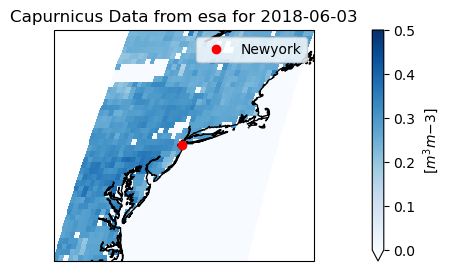

In [35]:
year  = 2018
month = 6
day   = 3
date = f'{year}-{month:02}-{day:02}'

y = 40.48908101650877
x = -74.0305856727883
n_x = 5
n_y = n_x
ny = dssm.sel(lon=slice(x - n_x, x + n_x),
                lat=slice(y + n_y, y - n_y),time=date)

fig, axs = plt.subplots(1, 1, figsize=(15,3), subplot_kw={'projection': ccrs.Robinson()})
ny.plot(transform=ccrs.PlateCarree(),ax=axs, cmap=plt.get_cmap('Blues'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[$m^{3} m{-3}$]'})
axs.plot(x,y,"ro",transform=ccrs.PlateCarree(),label="Newyork")

for p in [axs]:
    # p.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor='gray')
    p.axes.coastlines()

axs.legend();
axs.set_title(f"Capurnicus Data from esa for {date}")

# fig.savefig("output.png")


# Comparing products: SMAP & CCDS

These products produce different results, both can be compared to the in situ region:

first cut out the region:

In [36]:
mask = regionmask.mask_geopandas(outline_buffered, 
                                 smap_lprm['soil_moisture'].lon.to_numpy(), 
                                 smap_lprm['soil_moisture'].lat.to_numpy(),
                                 lon_name="lon",
                                 lat_name="lat")

In [38]:
cropped_ds_smap = smap_lprm.where(mask==0)
cropped_ds_ccds = dssm.where(mask==0)

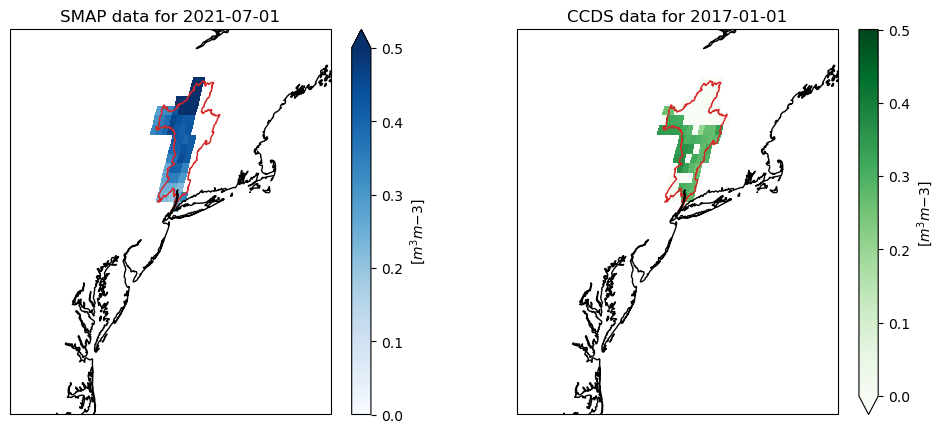

In [39]:

plot_ds_smap = cropped_ds_smap["soil_moisture"].isel(time=0)
plot_ds_ccds = cropped_ds_ccds.isel(time=0)

fig, [axs, axs2] = plt.subplots(1 ,2, figsize=(12,5), subplot_kw={'projection': ccrs.Robinson()})
plot_ds_smap.plot(transform=ccrs.PlateCarree(),ax=axs, cmap=plt.get_cmap('Blues'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[$m^{3} m{-3}$]'})
time =  cropped_ds_smap.isel(time=0).time.values
axs.set_title(f"SMAP data for {str(time)[:10]}")

plot_ds_ccds.plot(transform=ccrs.PlateCarree(),ax=axs2, cmap=plt.get_cmap('Greens'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[$m^{3} m{-3}$]'})
time =  cropped_ds_ccds.isel(time=0).time.values
axs2.set_title(f"CCDS data for {str(time)[:10]}")

for p in [axs, axs2]:
    p.axes.coastlines()
    outline.plot(ax=p, edgecolor="C3", facecolor="None",transform=ccrs.PlateCarree())

Text(0.5, 1.0, 'CCDS data compared to insitu observations')

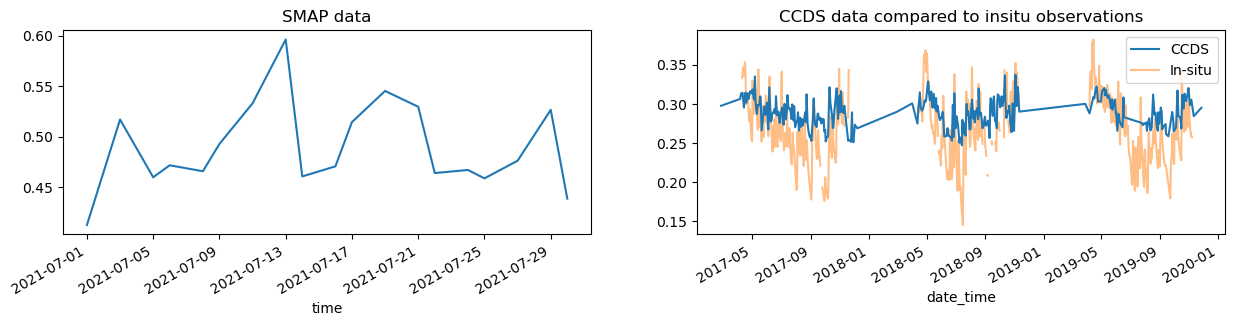

In [44]:
ds_mean_smap = cropped_ds_smap.mean(dim=["lat","lon"])
series_smap_sm = ds_mean_smap["soil_moisture"].to_pandas()
series_smap_sm_pos = series_smap_sm[series_smap_sm> 0]

ds_mean_ccds = cropped_ds_ccds.mean(dim=["lat","lon"])
series_ccds_sm = ds_mean_ccds.to_pandas()
series_ccds_sm_pos = series_ccds_sm[series_ccds_sm> 0]


fig, [ax, ax2] = plt.subplots(1,2,figsize=(15,3))
series_smap_sm_pos.plot(ax=ax)
ax.set_title('SMAP data')


series_ccds_sm_pos.plot(ax=ax2,label="CCDS")
stems_merged.loc[series_ccds_sm_pos.index.min():series_ccds_sm_pos.index.max()]["LyeBrook (0.0508 m)"].plot(ax=ax2, alpha=0.5,zorder=-1,label="In-situ")
ax2.legend()
ax2.set_title('CCDS data compared to insitu observations')

The plots above show the different products. The ccds show some promising data when conmpared with the ground obersvation data.